# Introduction

This notebook shows how to finetune a Vision Language Model (VLM) with the help of unsloth.

[unsloth](https://pypi.org/project/unsloth/) is a Python package that allows to finetune LLMs and VLMs.

In this example with we will finetune a VLM to map LaTeX images to LaTeX formulas.

The original notebook version is from unsloth:
https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Gemma3_(4B)-Vision.ipynb

I augmented their version with some additional notebook cells for inspection of data types, etc. for didactic reasons.



# Dependencies

In [49]:
!pip show unsloth

Name: unsloth
Version: 2025.12.9
Summary: 2-5X faster training, reinforcement learning & finetuning
Home-page: http://www.unsloth.ai
Author: Unsloth AI team
Author-email: info@unsloth.ai
License-Expression: Apache-2.0
Location: /home/juebrauer/miniconda3/envs/env_teaching/lib/python3.12/site-packages
Requires: accelerate, bitsandbytes, datasets, diffusers, hf_transfer, huggingface_hub, numpy, packaging, peft, protobuf, psutil, sentencepiece, torch, torchvision, tqdm, transformers, triton, trl, tyro, unsloth_zoo, wheel, xformers
Required-by: 


In [50]:
#%pip install unsloth

# Choose and load a VLM and its tokenizer

In [51]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

# Define the model to be used in the following here:
modelname = "unsloth/gemma-3-4b-pt"

# This will download the model automatically if it has not been downloaded before
# Then the model will be loaded to RAM
model, tokenizer = FastVisionModel.from_pretrained(
    modelname,
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.12.9: Fast Gemma3 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition. Num GPUs = 1. Max memory: 94.969 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


In [52]:
type(model)

transformers.models.gemma3.modeling_gemma3.Gemma3ForConditionalGeneration

In [53]:
type(tokenizer)

transformers.models.gemma3.processing_gemma3.Gemma3Processor

In [54]:
model.is_loaded_in_4bit

True

# Where is the VLM model stored?

Unsloth uses Hugging Face, so we should find the model after downloading here:

In [55]:
!ls -la ~/.cache/huggingface/hub/

total 20
drwxrwxr-x 5 juebrauer juebrauer 4096 Dez 28 08:23 .
drwxrwxr-x 5 juebrauer juebrauer 4096 Dez 28 08:23 ..
drwxrwxr-x 6 juebrauer juebrauer 4096 Dez 28 08:23 datasets--unsloth--LaTeX_OCR
drwxrwxr-x 4 juebrauer juebrauer 4096 Dez 28 08:23 .locks
drwxrwxr-x 6 juebrauer juebrauer 4096 Dez 28 08:18 models--unsloth--gemma-3-4b-pt-unsloth-bnb-4bit


In [56]:
!tree ~/.cache/huggingface/hub/models--unsloth*

/home/juebrauer/.cache/huggingface/hub/models--unsloth--gemma-3-4b-pt-unsloth-bnb-4bit
├── blobs
│   ├── 1299c11d7cf632ef3b4e11937501358ada021bbdf7c47638d13c0ee982f2e79c
│   ├── 1a6193244714d3d78be48666cb02cdbfac62ad86
│   ├── 372535c95c031316bee6050d3d4ed6f9a2f991ee391c7da4bd40b38ca13e90d0
│   ├── 453c7966d4b5d0b4a317c585989f64c58c2a6bf0
│   ├── 45c3df5b040e69e2a793ef94f4494e645247b87e
│   ├── 4667f2089529e8e7657cfb6d1c19910ae71ff5f28aa7ab2ff2763330affad795
│   ├── 77094b3be642d476fcd43c79f095c533cfae7fa9
│   ├── b1e00fc184f61b698181821169c6374cd5813e5c
│   ├── e17bde03d42feda32d1abfca6d3b598b9a020df7
│   └── f74dd51ec00123e7c0acd6ca47809d216e1925d2
├── refs
│   └── main
└── snapshots
    └── c1447b29557a9237103054ae5eef3e50932958b6
        ├── added_tokens.json -> ../../blobs/e17bde03d42feda32d1abfca6d3b598b9a020df7
        ├── config.json -> ../../blobs/77094b3be642d476fcd43c79f095c533cfae7fa9
        ├── generation_config.json -> ../../blobs/f74dd51ec00123e7c0acd6ca47809d216e1925d2

# Prepare model for finetuning

Now that we have the model loaded, we ...

- have to define which layers we want to finetune at all
- can define important LORA parameters as `r`

In [57]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [58]:
type(model)

peft.peft_model.PeftModelForCausalLM

In [59]:
print(str(model.base_model)[:2000])

LoraModel(
  (model): Gemma3ForConditionalGeneration(
    (model): Gemma3Model(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(4096, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): lora.Linear(
                    (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=16, bia

# Dataset for finetuning the VLM

The dataset we will use is [this here](https://huggingface.co/datasets/unsloth/LaTeX_OCR).

It consists of (generated LaTeX formula image, LaTeX code) pairs.

The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR) and also contains human written math formulas and synthetic hand written math formulas.

We use the [datasets Python package](https://huggingface.co/docs/datasets/index) from HuggingFace to download / get the data easily.

In [60]:
%pip show datasets

Name: datasets
Version: 4.3.0
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /home/juebrauer/miniconda3/envs/env_teaching/lib/python3.12/site-packages
Requires: dill, filelock, fsspec, httpx, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: trl, unsloth, unsloth_zoo
Note: you may need to restart the kernel to use updated packages.


In [61]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

Where is the dataset stored?

In [62]:
!ls -la ~/.cache/huggingface/datasets/

total 12
drwxrwxr-x 3 juebrauer juebrauer 4096 Dez 28 08:23 .
drwxrwxr-x 5 juebrauer juebrauer 4096 Dez 28 08:23 ..
-rw-rw-r-- 1 juebrauer juebrauer    0 Dez 28 08:43 _home_juebrauer_.cache_huggingface_datasets_unsloth___la_te_x_ocr_default_0.0.0_4da395c8a0253f4f30983cf08f2480f9bafbd561.lock
drwxrwxr-x 3 juebrauer juebrauer 4096 Dez 28 08:23 unsloth___la_te_x_ocr


In [63]:
!tree ~/.cache/huggingface/datasets/unsloth*

/home/juebrauer/.cache/huggingface/datasets/unsloth___la_te_x_ocr
└── default
    └── 0.0.0
        ├── 4da395c8a0253f4f30983cf08f2480f9bafbd561
        │   ├── dataset_info.json
        │   ├── la_te_x_ocr-test.arrow
        │   └── la_te_x_ocr-train.arrow
        ├── 4da395c8a0253f4f30983cf08f2480f9bafbd561_builder.lock
        └── 4da395c8a0253f4f30983cf08f2480f9bafbd561.incomplete_info.lock

4 directories, 5 files


In [64]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [65]:
dataset.features

{'image': Image(mode=None, decode=True), 'text': Value('string')}

In [66]:
dataset.column_names

['image', 'text']

In [67]:
dataset.shape

(68686, 2)

In [68]:
len(dataset)

68686

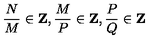

In [69]:
dataset[0]["image"]

In [87]:
type(dataset[0]["image"])

PIL.PngImagePlugin.PngImageFile

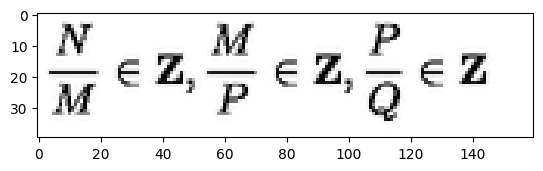

In [88]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0]["image"])
plt.show()

In [70]:
dataset[0]["text"]

'{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'

Let us render the LaTeX formula directly in the notebook:

In [71]:
from IPython.display import display, Math, Latex

latex_text = dataset[0]["text"]
display(Math(latex_text))

<IPython.core.display.Math object>

# Formatting the dataset for VLM finetuning

All vision finetuning tasks should be formatted as follows in unsloth:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Question}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": Answer} ]
},
]
```

We define a helper function in order to prepare this format:

In [72]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }

Now we will convert the complete dataset into the "correct" format for finetuning:

In [73]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

We look at how the conversations are structured for the first example:

In [74]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

# Does the model already know how to convert images to LaTeX formulas?

In [75]:
modelname

'unsloth/gemma-3-4b-pt'

In [76]:
# This is Gemma-3 specific and not necessary, e.g., for Qwen models
if "gemma" in modelname:

    from unsloth import get_chat_template

    tokenizer = get_chat_template(
        tokenizer,
        "gemma-3"
    )

In [78]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[3]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

orderEntry = \frac {1}{2}\sigma _\mu ^a \cdot A ^\mu
orderEntry = \frac {1}{2}\sigma _\mu ^a \cdot A ^\mu<eos>


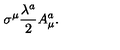

In [79]:
image

# Train the model

We will train the VLM using the [trl Python library](https://pypi.org/project/trl/) (TRL - Transformer Reinforcement Learning) by HuggingFace.

The `trl` library provides [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) - a Supervised Fine-Tuning (SFT) Trainer class for training language models.

In [81]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 100, # for a quick training the nr of training steps can be limited with this option
        #num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

In [82]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition. Max memory = 94.969 GB.
9.035 GB of memory reserved.


In [83]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


Step,Training Loss
1,2.456100
2,2.737400
3,3.068600
4,2.153700
5,2.040900
6,2.251300
7,1.706300
8,1.137800
9,0.784300
10,0.823100


In [84]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

199.2134 seconds used for training.
3.32 minutes used for training.
Peak reserved memory = 10.205 GB.
Peak reserved memory for training = 1.17 GB.
Peak reserved memory % of max memory = 10.746 %.
Peak reserved memory for training % of max memory = 1.232 %.


# Inference

No let's test the finetuned model!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

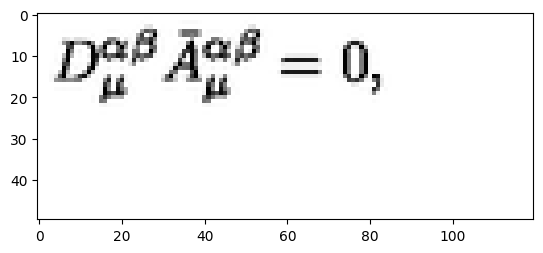

\dot D _ { \mu } ^ { \alpha \beta } { \overline A } _ { \mu } ^ { \alpha \beta } = 0 ,<end_of_turn>
--------------------------------------------------


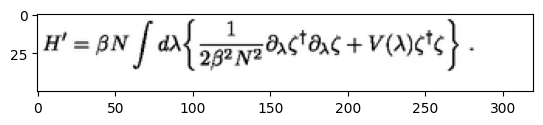

H ^ { \prime } = \beta N \int d \lambda \left\lbrace \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \xi \! ^ { + } \partial _ { \lambda } \xi \! + V ( \lambda ) \xi \! ^ { + } \xi \right\rbrace .<end_of_turn>
--------------------------------------------------


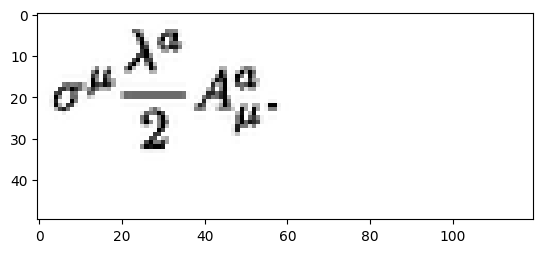

\sigma ^ { \mu } \frac { \lambda ^ { a } } { 2 } { A } ^ { a } _ { \mu } .<end_of_turn>
--------------------------------------------------


In [89]:
FastVisionModel.for_inference(model) # Enable for inference!

import matplotlib.pyplot as plt
for id in range(1,4):
    image = dataset[id]["image"]    
    plt.imshow(image)
    plt.show()

    instruction = "Write the LaTeX representation for this image."

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)
    
    print("-" * 50)

# Saving the finetuned model

To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [90]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

# Restoring and using a saved model

==((====))==  Unsloth 2025.12.9: Fast Gemma3 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition. Num GPUs = 1. Max memory: 94.969 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


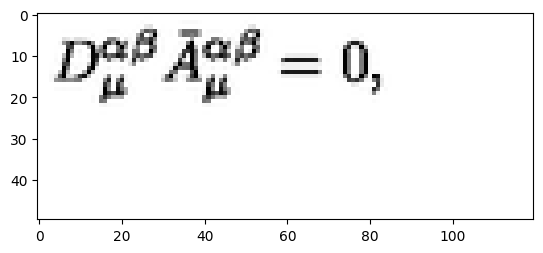

D _ { \mu } ^ { \alpha \beta } A _ { \mu } ^ { \alpha \beta } = 0 ,<end_of_turn>
--------------------------------------------------


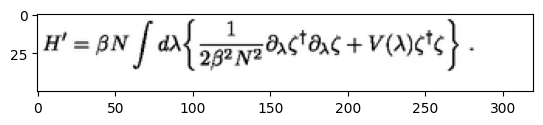

H ^ { \prime } = \beta N \int d \lambda \left \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \xi ^ { + } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \xi \right \} .<end_of_turn>
--------------------------------------------------


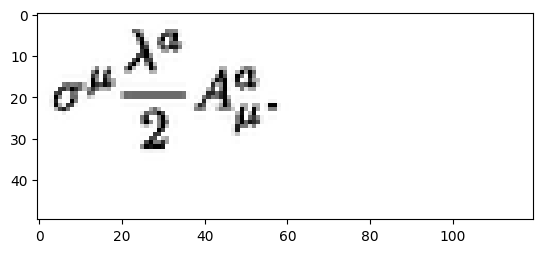

{ \sigma ^ { \mu } } { \frac { \lambda ^ { a } } { 2 } } A _ { \mu } ^ { a } .<end_of_turn>
--------------------------------------------------


In [2]:
# Reload the model or use the model from memory?
if True:

    # Reload the finetuned VLM
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

    # Reload the dataset
    from datasets import load_dataset
    dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

import matplotlib.pyplot as plt
for id in range(1,4):
    image = dataset[id]["image"]    
    plt.imshow(image)
    plt.show()

    instruction = "Write the LaTeX representation for this image."

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                    use_cache = True, temperature = 1.5, min_p = 0.1)
    
    print("-" * 50)

# Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

# GGUF / llama.cpp Conversion

To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("unsloth_finetune", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/unsloth_finetune", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("unsloth_finetune", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/unsloth_finetune", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("unsloth_finetune", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/unsloth_finetune", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/unsloth_finetune", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp.

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!


This notebook is licensed as [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme).
